In [1]:
import numpy as np
import pickle
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','training_set.csv'))
df_valid = pd.read_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','validation_set.csv'))
df_test  = pd.read_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','test_set.csv'))

In [ ]:
plotpath= '/global/u2/v/vboehm/codes/SDSS_PAE/figures/relabeled_retrained'

In [3]:
df_test = pd.concat([df_test,df_valid]).reset_index()

In [4]:
RUN             = '1'

seeds           = {'1':5123, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'


plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'


if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [5]:
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [6]:
df_test.rename(columns={' mjd':'MJD',' fiber':'fiber','plate':'plate'},inplace=True)
df_train.rename(columns={' mjd':'MJD',' fiber':'fiber','plate':'plate'},inplace=True)

In [7]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)
encoded_test = np.vstack((encoded_test,encoded_valid))

In [8]:
decoded          = {} 
decoded['train'],decoded['valid'], decoded['test'], mean, std  = np.load(os.path.join(root_decoded,'decoded_AE2_%s.npy'%(label_2)), allow_pickle=True)
decoded['test'] = np.vstack((decoded['test'],decoded['valid']))

In [9]:
df_test['ind1'] = np.arange(len(df_test))

In [10]:
top_outliers        = pd.read_csv('top8_logp_results_by_z.csv')
top_outliers['ind2'] = np.arange(len(top_outliers))

In [11]:
res     = df_test.merge(top_outliers,how='inner',on=['plate','MJD','fiber'])
indices = res.sort_values('ind2')['ind1']

In [12]:
encoded_an = encoded_test[indices]
decoded_an = decoded['test'][indices]

In [13]:
df_test = df_test.loc[indices]

In [14]:
import sys
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *
device   = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
model=torch.load(os.path.join(root_models,'conditional_SINF_%s_inpainted_denoised_data_relabeled'%(label_2)))

In [91]:
len(df_test)

40

In [16]:
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False


num_steps = 40  # how many optim steps to take
updates   = []
logps     = []

def logp(x,label):
    return torch.mean(-model.evaluate_density(x,label))

model.requires_grad_(False)
x     = torch.nn.Parameter(torch.Tensor(encoded_an).to(device), requires_grad=True)
label = torch.Tensor(df_test['new_label'].to_numpy()).to(device)
optim = torch.optim.Adam([x], lr=1e-1)
logp_ = logp(x,label)
logps.append(logp_.cpu().detach().numpy())
print(logp_,x,label)
for jj in range(num_steps):
    optim.zero_grad()
    updates.append(x.cpu().detach().numpy())
    logp_ = logp(x,label)
    logp_.backward()
    logps.append(logp_.cpu().detach().numpy())
    print(logp_)
    optim.step()

tensor(27.4200, device='cuda:0', grad_fn=<MeanBackward0>) Parameter containing:
tensor([[-2.7521e+01,  5.6899e+00, -9.2055e+00, -8.7175e+00, -8.0690e+00,
         -4.7608e+01,  8.9973e-01,  2.6123e+01, -3.0822e+01,  5.1974e+00],
        [-1.1588e+01,  3.1969e+00, -1.3888e+00, -1.5985e+01, -3.3938e+00,
         -1.2475e+01,  3.3540e-01,  1.7283e+01, -8.1334e+00, -1.5444e+00],
        [-2.1039e+00, -4.0611e-01, -8.3991e-01, -4.3204e+00, -1.8840e+00,
         -7.7994e+00, -3.5407e-01,  5.2463e+00, -1.9793e+00, -2.1217e+00],
        [-3.7429e+00,  1.2418e+00, -4.4990e-01,  2.9748e+00, -1.5939e+00,
         -6.9529e+00, -3.4069e-01,  3.0238e+00, -3.6679e+00, -9.8174e-02],
        [-2.9265e-01, -4.8555e-01, -1.5243e-01, -4.7241e-02,  3.6399e-01,
          1.2239e+00, -1.7170e-01, -3.5664e-02, -5.5381e-01, -7.1222e-01],
        [-1.7006e+00,  1.1930e-01, -1.9727e-01,  6.2313e-01, -7.2859e-01,
         -2.3815e+00, -2.3086e-01,  3.1792e-01, -3.6710e+00,  3.4474e-01],
        [-1.1345e+01,  1.9

In [17]:
np.save('40_min_1e-2.npy',[updates,logps])

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [27]:
res = np.load('40_min_1e-2.npy', allow_pickle=True)

In [28]:
x = res[0][-1]

In [29]:
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False


num_steps = 60  # how many optim steps to take
updates   = []
logps     = []

def logp(x,label):
    return torch.mean(-model.evaluate_density(x,label))

model.requires_grad_(False)
x     = torch.nn.Parameter(torch.Tensor(x).to(device), requires_grad=True)
label = torch.Tensor(df_test['new_label'].to_numpy()).to(device)
optim = torch.optim.Adam([x], lr=1e-1)
logp_ = logp(x,label)
logps.append(logp_.cpu().detach().numpy())
for jj in range(num_steps):
    optim.zero_grad()
    updates.append(x.cpu().detach().numpy())
    logp_ = logp(x,label)
    logp_.backward()
    logps.append(logp_.cpu().detach().numpy())
    print(logp_)
    optim.step()
    
np.save('100_min_1e-1.npy',[updates,logps])



tensor(16.5651, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(22.0677, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(21.0084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(20.5041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(20.0609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(19.8656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(19.1803, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(19.0070, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.6350, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.3951, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.3120, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.1649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(17.8107, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(17.5976, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(17.5183, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(17.2744, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(17.0715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(16.9693

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: expected CPU (got CUDA)

In [ ]:
num_steps = 100 
updates   = []
logps     = []
model.requires_grad_(False)
label = torch.Tensor(df_test['new_label'].to_numpy()).to(device)
optim = torch.optim.Adam([x], lr=1e-2)
logp_ = logp(x,label)
logps.append(logp_.cpu().detach().numpy())
for jj in range(num_steps):
    optim.zero_grad()
    updates.append(x.cpu().detach().numpy())
    logp_ = logp(x,label)
    logp_.backward()
    logps.append(logp_.cpu().detach().numpy())
    print(logp_)
    optim.step()
    
np.save('200_min_1e-2.npy',[updates,logps])

tensor(13.7971, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.4898, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.4099, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.4345, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.3361, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.2276, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.1938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.1920, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.1463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.0862, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.0701, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.0755, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.0325, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.0095, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.0100, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.9990, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.9777

In [6]:
path = os.path.join(root_decoded,'decoder_AE2_%s_run%s_inpainted_denoised'%(label_2, RUN))

In [1]:
### find nearest neighbors of new encoded spectra

In [75]:
df_test['plate']

135114     954
120080     350
41266      429
23135      472
1541      1657
670       1440
61461      412
32939     1649
64916      762
90863      435
19561     2513
10117     1833
122167    1755
139430     498
34156     2236
18165     1270
134921    1709
24317      294
5063      1587
106707    1928
64720      288
136444    2099
2006       285
92516     1457
46562     1436
25000     1755
634        934
47942     2532
32614      961
82907      285
10238      470
74495      744
86421     2150
25535     1750
109223     929
56687     2112
37331      905
106926    1377
123986    1195
8159      2137
Name: plate, dtype: int64

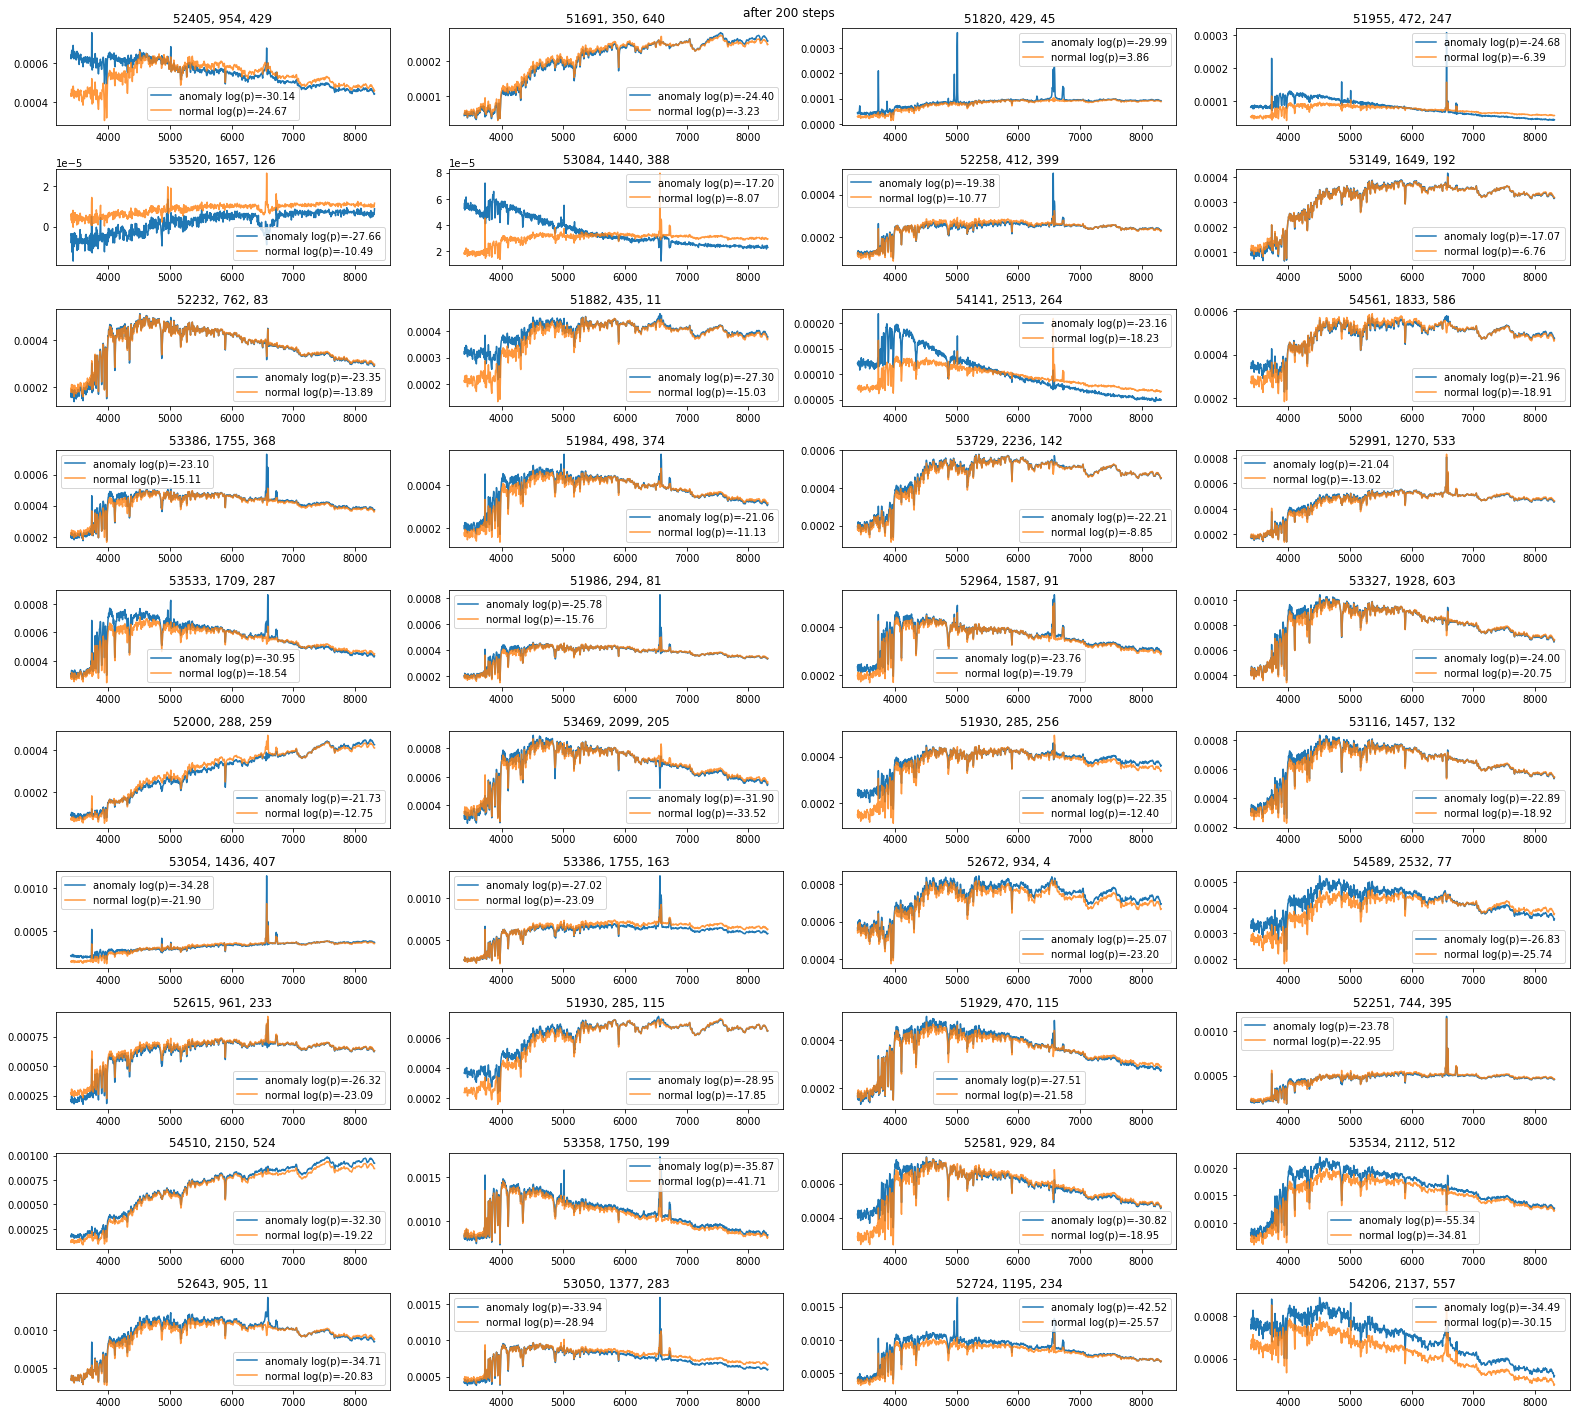

In [22]:
updates,logps = np.load('200_min_1e-2.npy', allow_pickle=True)


updates = np.asarray(updates)

final_guess = updates[-1,:,:] 

from scipy.spatial import KDTree as KDTree

tree = KDTree(encoded_train, leafsize=10)

dis, ind = tree.query(final_guess, k=1)

NN_train       = torch.Tensor(encoded_train[ind]).to(device)
label_train    = torch.Tensor(df_test['new_label'].to_numpy()).to(device)#torch.Tensor(df_train['new_label'].to_numpy()[ind]).to(device)
logp_train     = model.evaluate_density(NN_train, label = label_train).detach().cpu().numpy()

enc_test_an_tensor   = torch.nn.Parameter(torch.Tensor(encoded_an).to(device), requires_grad=True)
label_test_an_tensor = torch.Tensor(df_test['new_label'].to_numpy()).to(device)
logp_test = model.evaluate_density(enc_test_an_tensor, label = label_test_an_tensor).detach().cpu().numpy()

len(enc_test_an_tensor)
df_test = df_test.reset_index(drop=True)

fig, ax = plt.subplots(10,4,figsize=(22,20))
fig.suptitle('after 200 steps')
ax = ax.flatten()
for ii in range(40):
#    if ii==0:
    ax[ii].set_title('%d, %d, %d'%(df_test['MJD'][ii], df_test['plate'][ii], df_test['fiber'][ii]))
    ax[ii].plot(new_wl[1:],decoded_an[ii]/new_wl[1:], label='anomaly log(p)=%.2f'%logp_test[ii])
    ax[ii].plot(new_wl[1:],decoded['train'][ind[ii]]/new_wl[1:],alpha=0.8, label='normal log(p)=%.2f'%logp_train[ii])
    ax[ii].legend()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'200steps.pdf'), bbox_inches='tight')
plt.show()

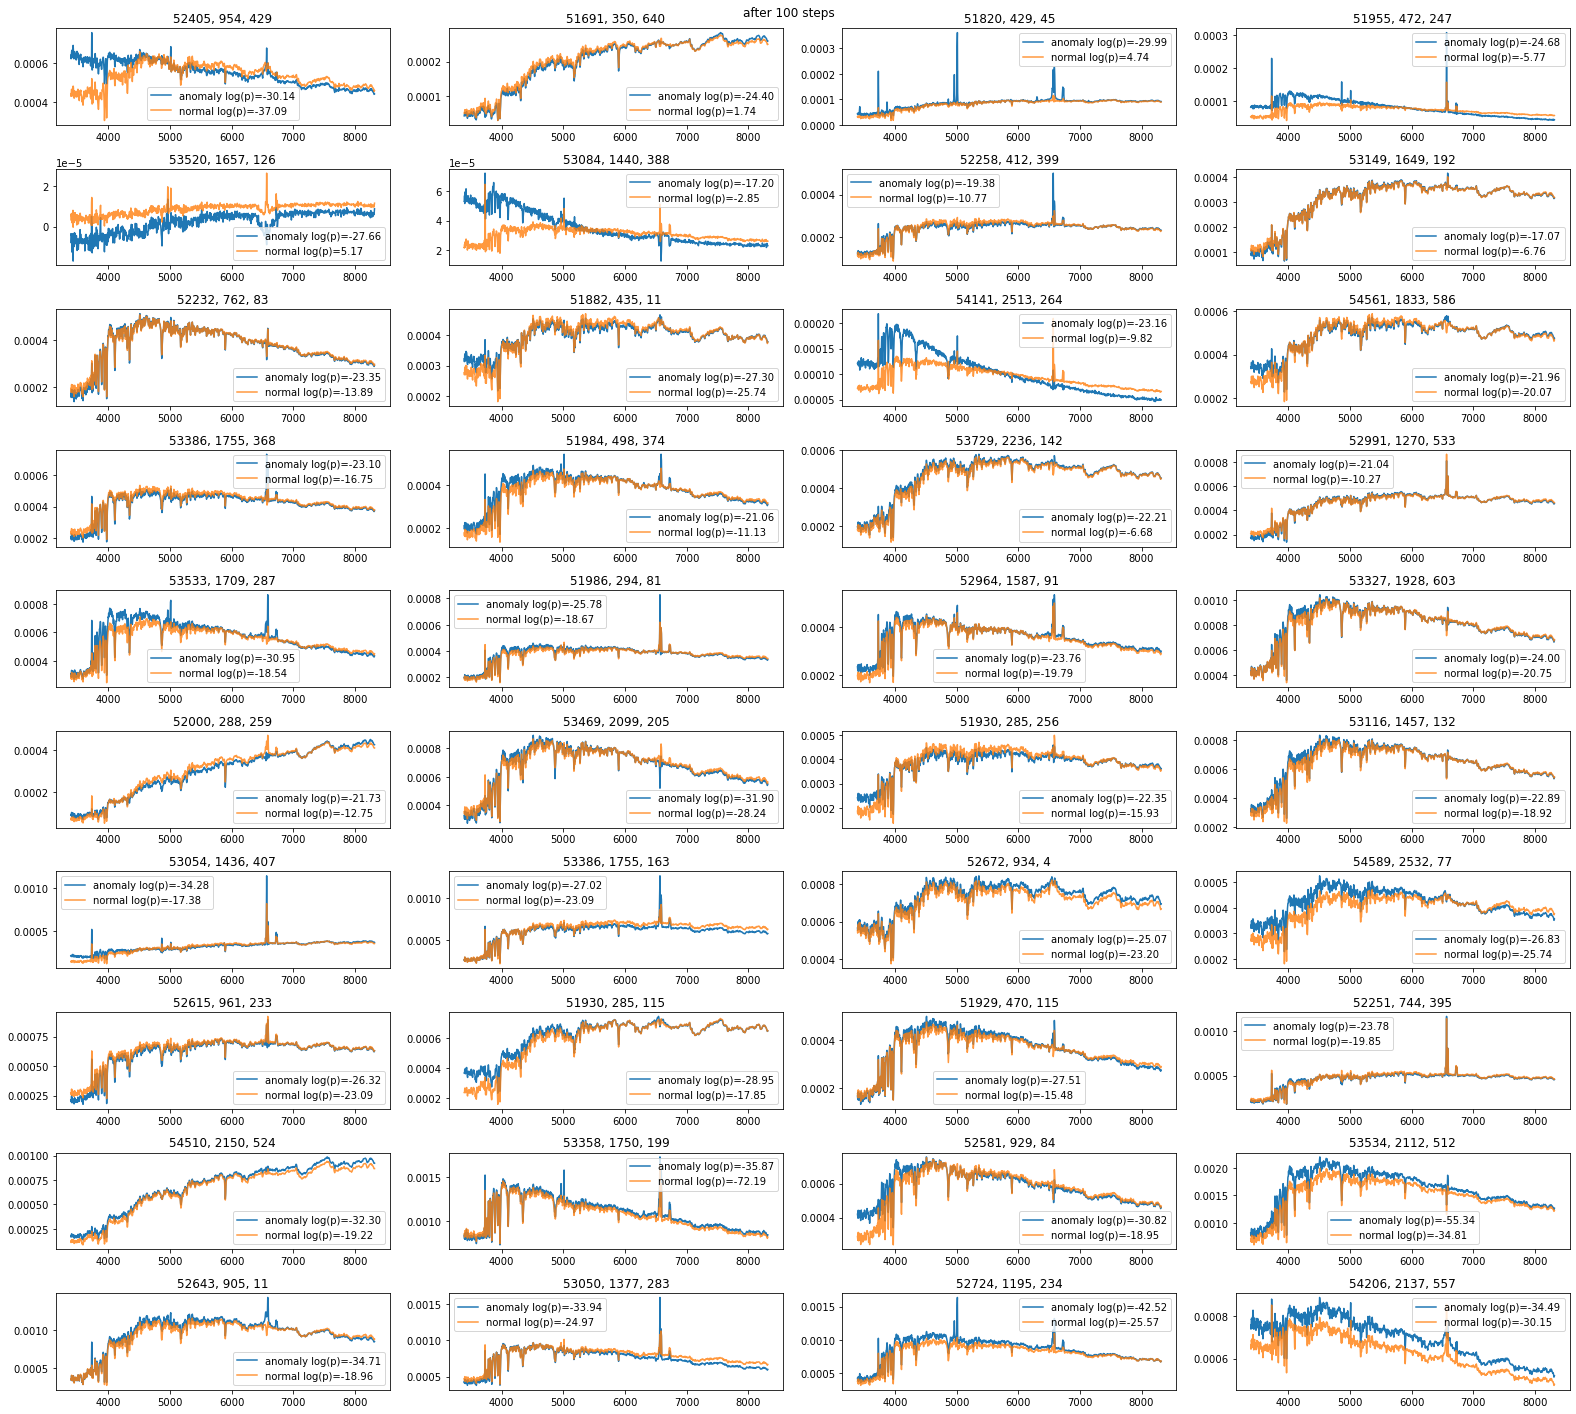

In [23]:
updates,logps = np.load('200_min_1e-2.npy', allow_pickle=True)


updates = np.asarray(updates)

final_guess = updates[0,:,:] 

from scipy.spatial import KDTree as KDTree

tree = KDTree(encoded_train, leafsize=10)

dis, ind = tree.query(final_guess, k=1)

NN_train       = torch.Tensor(encoded_train[ind]).to(device)
label_train    = torch.Tensor(df_train['new_label'].to_numpy()[ind]).to(device)
logp_train     = model.evaluate_density(NN_train, label = label_train).detach().cpu().numpy()

enc_test_an_tensor   = torch.nn.Parameter(torch.Tensor(encoded_an).to(device), requires_grad=True)
label_test_an_tensor = torch.Tensor(df_test['new_label'].to_numpy()).to(device)
logp_test = model.evaluate_density(enc_test_an_tensor, label = label_test_an_tensor).detach().cpu().numpy()

len(enc_test_an_tensor)

fig, ax = plt.subplots(10,4,figsize=(22,20))
fig.suptitle('after 100 steps')
ax = ax.flatten()
for ii in range(40):
#    if ii==0:
    ax[ii].set_title('%d, %d, %d'%(df_test['MJD'][ii], df_test['plate'][ii], df_test['fiber'][ii]))
    ax[ii].plot(new_wl[1:],decoded_an[ii]/new_wl[1:], label='anomaly log(p)=%.2f'%logp_test[ii])
    ax[ii].plot(new_wl[1:],decoded['train'][ind[ii]]/new_wl[1:],alpha=0.8, label='normal log(p)=%.2f'%logp_train[ii])
    ax[ii].legend()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'100steps.pdf'), bbox_inches='tight')
plt.show()

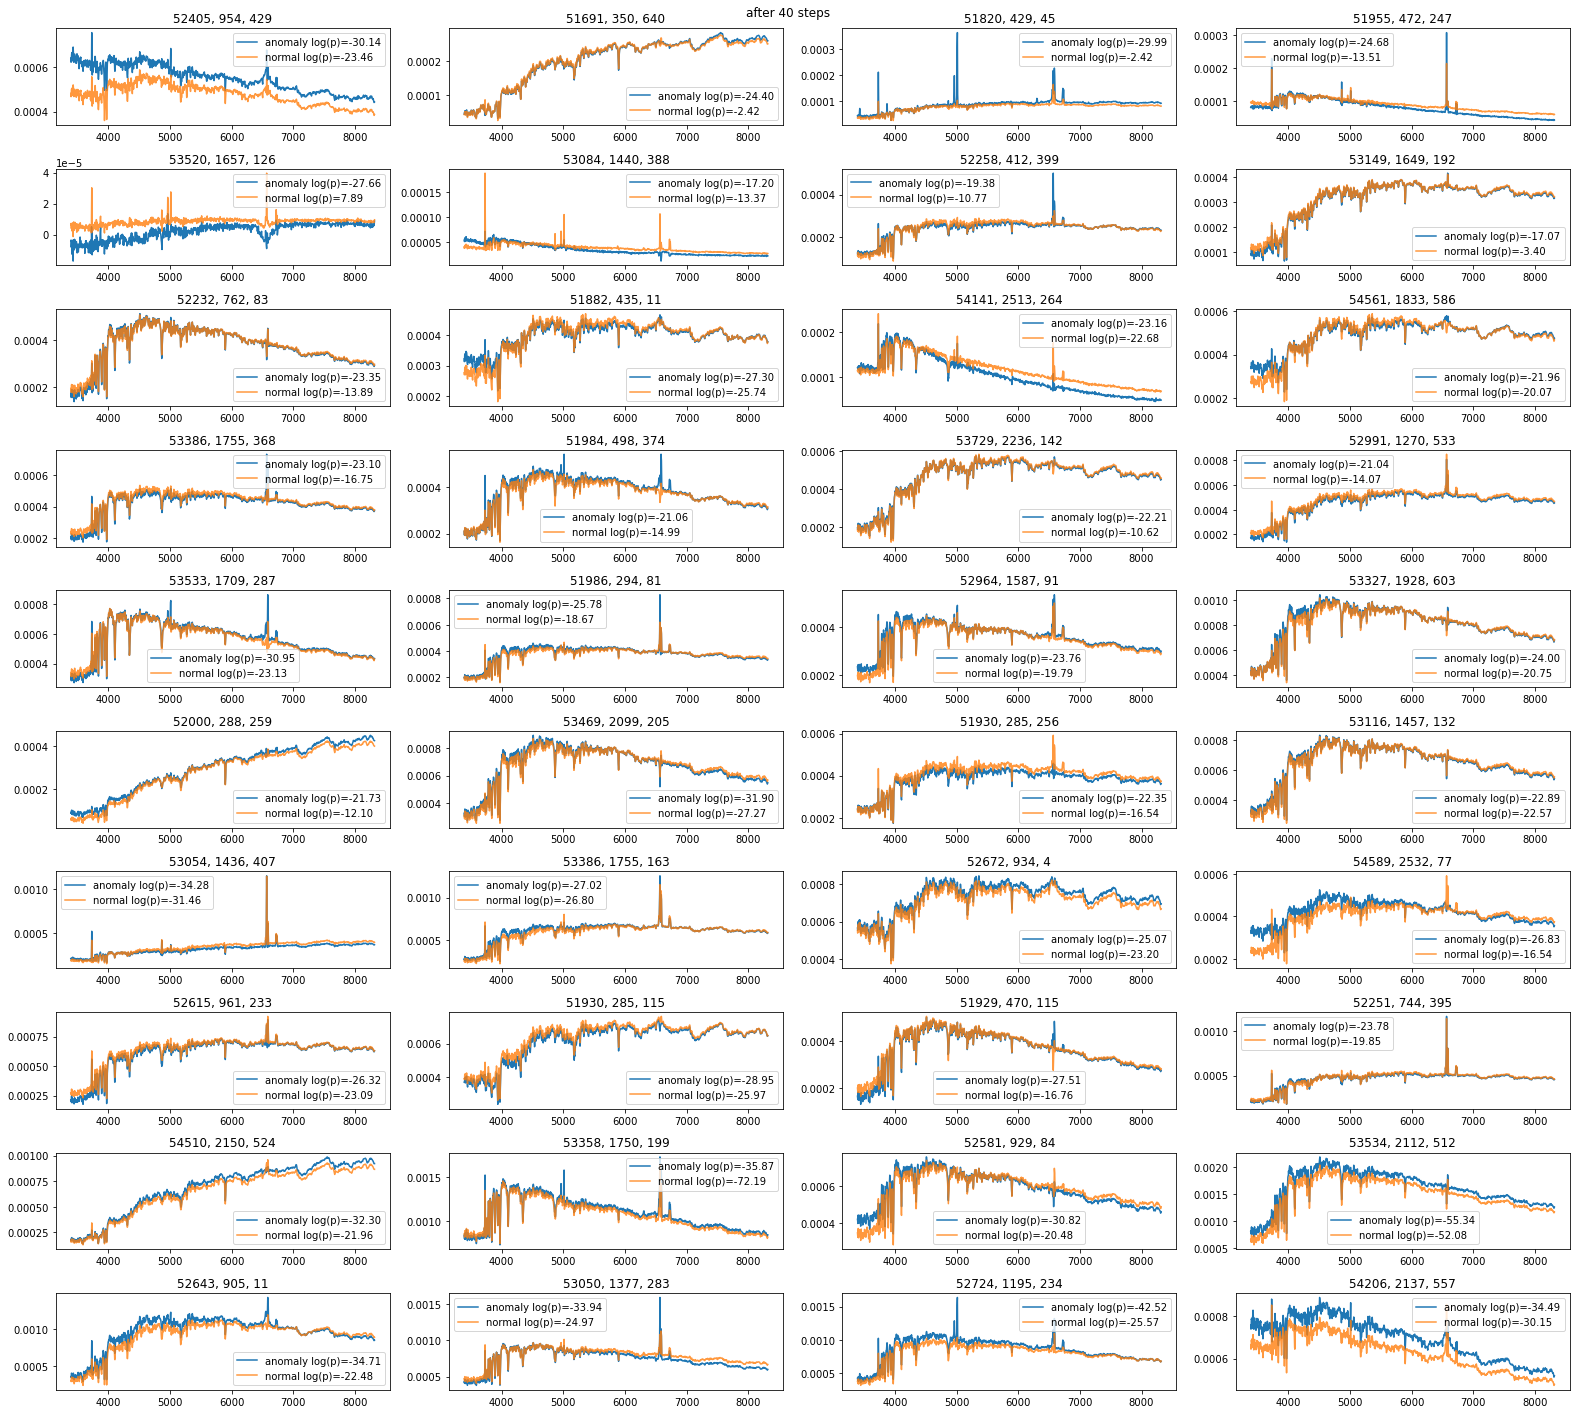

In [24]:
updates,logps = np.load('40_min_1e-2.npy', allow_pickle=True)


updates = np.asarray(updates)

final_guess = updates[-1,:,:] 

from scipy.spatial import KDTree as KDTree

tree = KDTree(encoded_train, leafsize=10)

dis, ind = tree.query(final_guess, k=1)

NN_train       = torch.Tensor(encoded_train[ind]).to(device)
label_train    = torch.Tensor(df_train['new_label'].to_numpy()[ind]).to(device)
logp_train     = model.evaluate_density(NN_train, label = label_train).detach().cpu().numpy()

enc_test_an_tensor   = torch.nn.Parameter(torch.Tensor(encoded_an).to(device), requires_grad=True)
label_test_an_tensor = torch.Tensor(df_test['new_label'].to_numpy()).to(device)
logp_test = model.evaluate_density(enc_test_an_tensor, label = label_test_an_tensor).detach().cpu().numpy()

len(enc_test_an_tensor)

fig, ax = plt.subplots(10,4,figsize=(22,20))
ax = ax.flatten()
fig.suptitle('after 40 steps')
for ii in range(40):
#    if ii==0:
    ax[ii].set_title('%d, %d, %d'%(df_test['MJD'][ii], df_test['plate'][ii], df_test['fiber'][ii]))
    ax[ii].plot(new_wl[1:],decoded_an[ii]/new_wl[1:], label='anomaly log(p)=%.2f'%logp_test[ii])
    ax[ii].plot(new_wl[1:],decoded['train'][ind[ii]]/new_wl[1:],alpha=0.8, label='normal log(p)=%.2f'%logp_train[ii])
    ax[ii].legend()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'40steps.pdf'), bbox_inches='tight')

plt.show()